In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 125
import seaborn as sns
from Bio import SeqIO, Seq
import scipy.stats as st
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import glob, os, yaml, subprocess, itertools, sparse

who_variants_combined = pd.read_csv("who_confidence_2021.csv")
samples_summary = pd.read_csv("../data/samples_summary.csv")

import warnings
warnings.filterwarnings(action='ignore')

# CHANGE ANALYSIS DIR BEFORE RUNNING THE NOTEBOOK!
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'

In [2]:
drugs_lst = ["Delamanid", "Bedaquiline", "Clofazimine", "Ethionamide", "Linezolid",
             "Moxifloxacin", "Capreomycin", "Amikacin", "Pretomanid", "Pyrazinamide", "Kanamycin", "Levofloxacin",
             "Streptomycin", "Ethambutol", "Isoniazid", "Rifampicin", 
            ]

drug_abbr_dict = {"Delamanid": "DLM",
                  "Bedaquiline": "BDQ",
                  "Clofazimine": "CFZ",
                  "Ethionamide": "ETH",
                  "Linezolid": "LZD",
                  "Moxifloxacin": "MXF",
                  "Capreomycin": "CAP",
                  "Amikacin": "AMI",
                  "Pretomanid": "PTM",
                  "Pyrazinamide": "PZA",
                  "Kanamycin": "KAN",
                  "Levofloxacin": "LEV",
                  "Streptomycin": "STM",
                  "Ethambutol": "EMB",
                  "Isoniazid": "INH",
                  "Rifampicin": "RIF"
                 }

# Write Final Dataframes for the Binary Analysis to an Excel File

Each drug will have a separate Excel file. Each file will have 16 sheets, one for each model.

For INH, surprising that hadA variants are found with high associations. Might be homoplastic!
For PZA, surprising that clpC1_c.2302T>C co-occurs with pncA_p.His57Asp

In [13]:
def export_binary_mic_analyses(drugs_lst, folder, analyses_lst):
    
    if not os.path.isdir(f"../results/{folder}"):
        os.mkdir(f"../results/{folder}")
    
    for drug in np.sort(drugs_lst):

        all_analyses = {}

        for i, model_path in enumerate(analyses_lst):

            # some may not be there. Usually this is Pretomanid because there are no tier 2 genes
            analysis_fName = os.path.join(analysis_dir, drug, folder, model_path, "model_analysis.csv")
            
            if os.path.isfile(analysis_fName):
                
                add_analysis = pd.read_csv(analysis_fName)
                add_analysis["Tier"] = [2 if "+2" in model_path else 1][0]
                
                # the phenotype category is only relevant for the binary analysis
                if folder == "BINARY":
                    add_analysis["Phenos"] = ["ALL" if "ALL" in model_path else "WHO"][0]
                    
                add_analysis["pool_type"] = model_path.split("_")[-1]
                add_analysis["synonymous"] = int("withSyn" in model_path)
                add_analysis["HET"] = ["DROP" if "drop" in model_path else "AF"][0]

                # remove principal components
                add_analysis = add_analysis.loc[~add_analysis["mutation"].str.contains("PC", case=True)]

                all_analyses[f"Model_{i+1}"] = add_analysis

        with pd.ExcelWriter(f"../results/{folder}/{drug}.xlsx") as file:
            for key, val in all_analyses.items():
                val.to_excel(file, sheet_name=key, index=False)
                    
            print(f"Finished {drug}")

In [6]:
# hard coded paths to preserve the model hierarchy
binary_analyses_lst = ["tiers=1/phenos=WHO/dropAF_noSyn_poolSeparate",
                      "tiers=1/phenos=WHO/dropAF_noSyn_poolALL",
                      "tiers=1/phenos=WHO/dropAF_noSyn_unpooled",
                      "tiers=1/phenos=WHO/dropAF_withSyn_poolSeparate",
                      "tiers=1+2/phenos=WHO/dropAF_noSyn_poolSeparate",
                      "tiers=1+2/phenos=WHO/dropAF_noSyn_poolALL",
                      "tiers=1+2/phenos=WHO/dropAF_noSyn_unpooled",
                      "tiers=1+2/phenos=WHO/dropAF_withSyn_poolSeparate",
                      "tiers=1/phenos=ALL/dropAF_noSyn_poolSeparate",
                      "tiers=1/phenos=ALL/dropAF_noSyn_poolALL",
                      "tiers=1/phenos=ALL/dropAF_noSyn_unpooled",
                      "tiers=1/phenos=ALL/dropAF_withSyn_poolSeparate",
                      "tiers=1+2/phenos=ALL/dropAF_noSyn_poolSeparate",
                      "tiers=1+2/phenos=ALL/dropAF_noSyn_poolALL",
                      "tiers=1+2/phenos=ALL/dropAF_noSyn_unpooled",
                      "tiers=1+2/phenos=ALL/dropAF_withSyn_poolSeparate",
                      "tiers=1/phenos=WHO/encodeAF_noSyn_poolSeparate",
                      "tiers=1+2/phenos=WHO/encodeAF_noSyn_poolSeparate",
                      "tiers=1/phenos=ALL/encodeAF_noSyn_poolSeparate",
                      "tiers=1+2/phenos=ALL/encodeAF_noSyn_poolSeparate",
                    ]

export_binary_mic_analyses(drugs_lst, "BINARY", binary_analyses_lst)

Finished Amikacin
Finished Bedaquiline
Finished Capreomycin
Finished Clofazimine
Finished Delamanid
Finished Ethambutol
Finished Ethionamide
Finished Isoniazid
Finished Kanamycin
Finished Levofloxacin
Finished Linezolid
Finished Moxifloxacin
Finished Pretomanid
Finished Pyrazinamide
Finished Rifampicin
Finished Streptomycin


# MIC Analyses

In [14]:
# hard coded paths to preserve the model hierarchy
mic_analyses_lst = ["tiers=1/dropAF_noSyn_poolSeparate",
                    "tiers=1/dropAF_noSyn_unpooled",
                    "tiers=1+2/dropAF_noSyn_poolSeparate",
                    "tiers=1+2/dropAF_noSyn_unpooled",
                   ]

export_binary_mic_analyses(drugs_lst, "MIC", mic_analyses_lst)

Finished Amikacin
Finished Bedaquiline
Finished Capreomycin
Finished Clofazimine
Finished Delamanid
Finished Ethambutol
Finished Ethionamide
Finished Isoniazid
Finished Kanamycin
Finished Levofloxacin
Finished Linezolid
Finished Moxifloxacin
Finished Pretomanid
Finished Pyrazinamide
Finished Rifampicin
Finished Streptomycin


# Binary Analysis Summaries File

## Make an Excel file summarizing the results for each drug for the binary analyses

## Break down results by FDR (Significant), OR > 1, Primary Analysis, PPV ≥ 25%, and True Positive (# with variant and resistant) ≥ 5

In [15]:
def generate_summary_data(drug, folder):
    
    # read in Excel file with all the sheets 
    df = pd.read_excel(f"../results/{folder}/{drug}.xlsx", sheet_name=None)

    # combine sheets into a single dataframe and keep only the first instance of every mutation
    df = pd.concat(list(df.values())).drop_duplicates("mutation", keep="first")

    # OR > 1 or OR < 1 --> associated with resistance or susceptibility
    df["OR>1"] = (df["Odds_Ratio"] > 1)
    df["PPV_LB≥0.25"] = (df["PPV_LB"] >= 0.25)
    df["TP≥5"] = (df["TP"] >= 5)

    df[["OR>1", "PPV_LB≥0.25", "TP≥5"]] = df[["OR>1", "PPV_LB≥0.25", "TP≥5"]].fillna(0).astype(int)
    df["pooled"] = [0 if "unpooled" in val else 1 for val in df["pool_type"].values]

    summary_cols = ["OR>1", "PPV_LB≥0.25", "TP≥5", "Significant", "Tier", "Phenos", "synonymous", "pooled"]
    summary = pd.DataFrame(df[summary_cols].value_counts()).reset_index().rename(columns={0:"Count"})
    summary = summary[["Count"] + summary_cols].sort_values(by=summary_cols, ascending=[False, False, False, False, True, False, True, True])

    summary.loc[(summary["OR>1"] == 1) & 
                (summary["PPV_LB≥0.25"] == 1) &
                (summary["TP≥5"] == 1), "Expert_PASS"
                ] = 1

    summary["Expert_PASS"] = summary["Expert_PASS"].fillna(0).astype(int)

    return summary.rename(columns={"Tier": "Gene_Tier", "pooled": "LOF_inframe_pooling"}).reset_index(drop=True)

In [16]:
analysis_summaries = {}
folder = "BINARY"

for drug in np.sort(drugs_lst):
    
    if os.path.isfile(f"../results/{folder}/{drug}.xlsx"):
        analysis_summaries[drug] = generate_summary_data(drug, folder)
    
# write results to an Excel file, where each sheet name is a drug
with pd.ExcelWriter("../results/ALLDrugs_summaries.xlsx") as file:
   
    for key, val in analysis_summaries.items():
        val.to_excel(file, sheet_name=key, index=False)

# CC vs. CC-ATU Analyses

Export only variants that would pass the Expert rule:

<ul>
    <li>Odds Ratio > 1</li>
    <li>N_resistant (i.e. true positive) ≥ 5</li>
    <li>PPV_LB ≥ 0.25</li>
    <li>Benjamini-Hochberg p-value < 0.01</li>
</ul>

In [ ]:
def export_cc_atu_analyses(drugs_lst, pval_thresh=0.01):
    '''
    This function combines the CC and CC-ATU analyses for each drug. 
    '''
    
    if not os.path.isdir("../results/ATU"):
        os.mkdir("../results/ATU")
    
    # hard coded paths to preserve the model hierarchy
    analysis_paths = ["tiers=1/dropAF_noSyn_poolSeparate",
                      "tiers=1/dropAF_noSyn_poolALL",
                      "tiers=1/dropAF_noSyn_unpooled",
                      "tiers=1+2/dropAF_noSyn_poolSeparate",
                      "tiers=1+2/dropAF_noSyn_poolALL",
                      "tiers=1+2/dropAF_noSyn_unpooled",
    ]
    
    for drug in drugs_lst:
        
        all_analyses = {}
        
        for i, model_path in enumerate(analysis_paths):

            if os.path.isfile(os.path.join(analysis_dir, drug, "ATU", model_path, "model_analysis_CC.csv")):
            
                cc = pd.read_csv(os.path.join(analysis_dir, drug, "ATU", model_path, "model_analysis_CC.csv"))
                cc_atu = pd.read_csv(os.path.join(analysis_dir, drug, "ATU", model_path, "model_analysis_CC_ATU.csv"))

                cc.loc[(cc["Odds_Ratio"] > 1) & 
                       (cc["TP"] >= 5) &
                       (cc["PPV_LB"] >= 0.25) & 
                       (cc["BH_pval"] < pval_thresh), "Expert_PASS"
                      ] = 1

                cc_atu.loc[(cc_atu["Odds_Ratio"] > 1) & 
                           (cc_atu["TP"] >= 5) &
                           (cc_atu["PPV_LB"] >= 0.25) & 
                           (cc_atu["BH_pval"] < pval_thresh), "Expert_PASS"
                          ] = 1

                cc["ATU"] = 0
                cc_atu["ATU"] = 1

                combined_df = pd.concat([cc.query("Expert_PASS == 1"), cc_atu.query("Expert_PASS == 1")])
                del combined_df["Expert_PASS"]
                
                combined_df["Tier"] = [2 if "+2" in model_path else 1][0]
                combined_df["Phenos"] = ["ALL" if "ALL" in model_path else "WHO"][0]
                combined_df["pool_type"] = model_path.split("_")[-1]
                combined_df["synonymous"] = int("withSyn" in model_path)
                combined_df["HET"] = ["DROP" if "drop" in model_path else "AF"][0]

                # remove principal components
                combined_df = combined_df.loc[~combined_df["mutation"].str.contains("PC", case=True)]
            
                all_analyses[f"Model_{i+1}"] = combined_df.sort_values("Odds_Ratio", ascending=False)

        if len(all_analyses) > 0:
                
            with pd.ExcelWriter(f"../results/ATU/{drug}.xlsx") as file:

                for key, val in all_analyses.items():
                    val.to_excel(file, sheet_name=key, index=False)
                  
            print(f"Finished {drug}!")

In [15]:
export_cc_atu_analyses(drugs_lst)

Finished Delamanid!
Finished Bedaquiline!
Finished Clofazimine!
Finished Ethionamide!
Finished Linezolid!
Finished Moxifloxacin!
Finished Amikacin!
Finished Kanamycin!
Finished Levofloxacin!
Finished Ethambutol!
Finished Isoniazid!
Finished Rifampicin!


# Volcano Plots

In [26]:
def volcano_plot(drug, folder, plot_y="log_neg_log_pval", pval_col="BH_pval", color_col="Significant", saveFig=None):
    '''
    This function generates a volcano scatterplot of p-values against odds ratios to visualize the results for each drug. 
    
    It generates 2 plots for each drug: one for the primary analyses and another for the additional variants picked up by the secondary analyses. Separating them makes the secondary results
    easier to see because the effect sizes for those are much smaller, and they can get obscured by the primary analysis results. 
    
    Arguments:
    
        df = dataframe of results
        plot_x = column in df to plot as the x variable
        plot_y = column in df to plot as the y variable
        pval_col = p-value column to plot (i.e. p-value, Bonferroni, or Benjamini-Hochberg)
        drug = drug name for plotting
        color_col = column in df to color point by. Default is Significant
        or_thresh = to clean up the plot, you can exclude some mutations with very small effect sizes. or_thresh should be a value in [0, ∞). i.e. a threshold of 0.01 will
                    exclude variants with odds ratios in [0.99, 1.01]
        save_fig = file name to save plot to. If it is None, the plot is rendered in the notebook.
        
    Primary analysis: Tier = 1, Phenos = WHO, unpooled = False, synonymous = False, HET mutations = DROP
    
    The function computes the log odds ratio, negative logarithm of p-values, and the logarithm of the negative log of p-values. 
    It plots the logarithm of the negative log of p-values vs. the coefficient in regression (linear or logistic). The log of the logistic regression coefficient is the log-Odds
    '''
    
    # read in Excel file with all the sheets 
    fName = f"../results/{folder}/{drug}.xlsx"
    
    if os.path.isfile(fName):
        df = pd.read_excel(fName, sheet_name=None)

        # combine sheets into a single dataframe and keep only the first instance of every mutation
        df = pd.concat(list(df.values())).drop_duplicates("mutation", keep="first")

        plot_df = df.copy()
        
        if plot_df[pval_col].min() == 0:
            second_smallest = np.sort(np.unique(plot_df[pval_col]))[1]
            plot_df[pval_col] += second_smallest

        plot_df["neg_log_pval"] = -np.log(plot_df[pval_col])
        plot_df["log_neg_log_pval"] = np.log(plot_df["neg_log_pval"])
        
        if folder == "BINARY":
            plot_df["log-OR"] = np.log(plot_df["Odds_Ratio"])
            plot_col = "log-OR"
        else:
            plot_col = "coef"
            
        plot_df.loc[(plot_df["Tier"]==1) & 
                    (plot_df["Phenos"]=='WHO') & 
                    (plot_df["pool_type"]=='poolSeparate') & 
                    (plot_df["synonymous"]==0) & 
                    (plot_df["HET"]=='DROP'), 
                    "Analysis"] = "Primary"
        plot_df["Analysis"] = plot_df["Analysis"].fillna("Secondary")

        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        
        sns.scatterplot(data=plot_df.query("Analysis=='Primary'"), 
                        x=plot_col, 
                        y=plot_y, 
                        alpha=0.8,
                        hue=color_col, 
                        linewidth=0.25,
                        edgecolor='white',
                        s=30,
                        palette={1:sns.color_palette("tab10").as_hex()[0], 0:"lightgray"},
                        #palette={"Primary": sns.color_palette("Set2").as_hex()[2], "Secondary": sns.color_palette("Set2").as_hex()[1]},
                        ax=ax[0]
                       )
        sns.scatterplot(data=plot_df.query("Analysis=='Secondary'"), 
                        x=plot_col, 
                        y=plot_y, 
                        alpha=0.8,
                        hue=color_col,
                        linewidth=0.25,
                        edgecolor='white',
                        s=30,
                        palette={1:sns.color_palette("tab10").as_hex()[0], 0:"lightgray"},
                        #palette={"Primary": sns.color_palette("Set2").as_hex()[2], "Secondary": sns.color_palette("Set2").as_hex()[1]},
                        ax=ax[1]
                       )

        for axis in ax:
            if plot_y[:3] == 'log':
                axis.set_ylabel("Log(-Log(p-value))")
            else:
                axis.set_ylabel("-Log(p-value)")

        if len(plot_df.query("Analysis=='Primary'")) > 0:
            bound_0 = np.max(np.abs(plot_df.query("Analysis=='Primary'")[plot_col]))*1.1
            
            ax[0].set_title(f"Primary {folder} Analysis for {drug}")
            ax[0].set_xlim(-bound_0, bound_0)
            
        if len(plot_df.query("Analysis=='Secondary'")) > 0:
            bound_1 = np.max(np.abs(plot_df.query("Analysis=='Secondary'")[plot_col]))*1.1
            
            ax[1].set_title(f"Secondary {folder} Analysis for {drug}")
            ax[1].set_xlim(-bound_1, bound_1)

        for axis in ax:
            if folder == "BINARY":
                axis.set_xlabel("Regression Log-Odds")
            else:
                axis.set_xlabel("Regression Coefficient")
            axis.legend().set_visible(False)

        sns.despine()

        if saveFig is not None:
            if not os.path.isdir(os.path.dirname(saveFig)):
                os.makedir(os.path.dirname(saveFig))
            plt.savefig(saveFig, dpi=300, bbox_inches="tight")
        else:
            plt.show()

        return plot_df

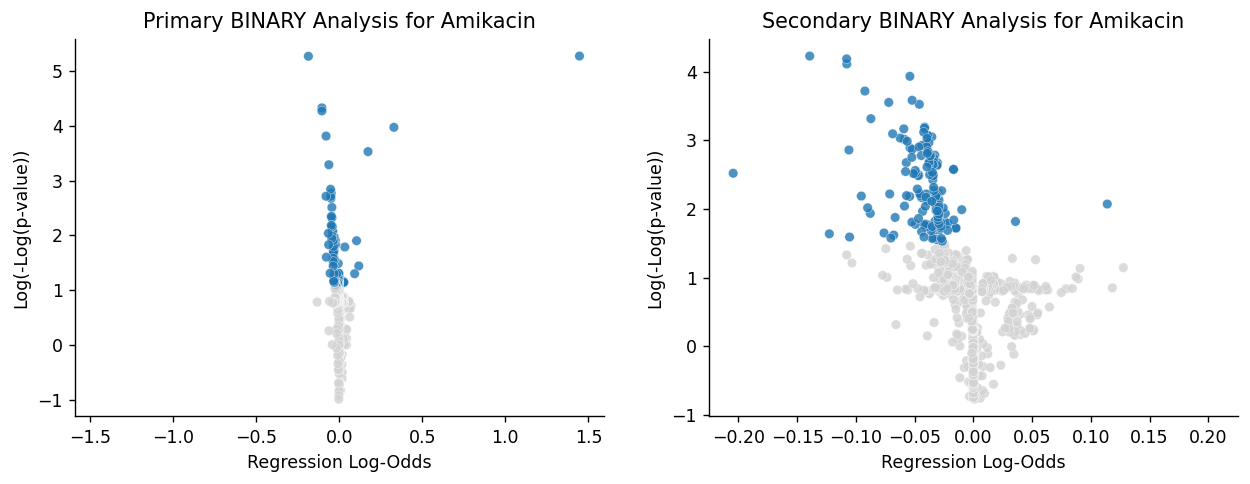

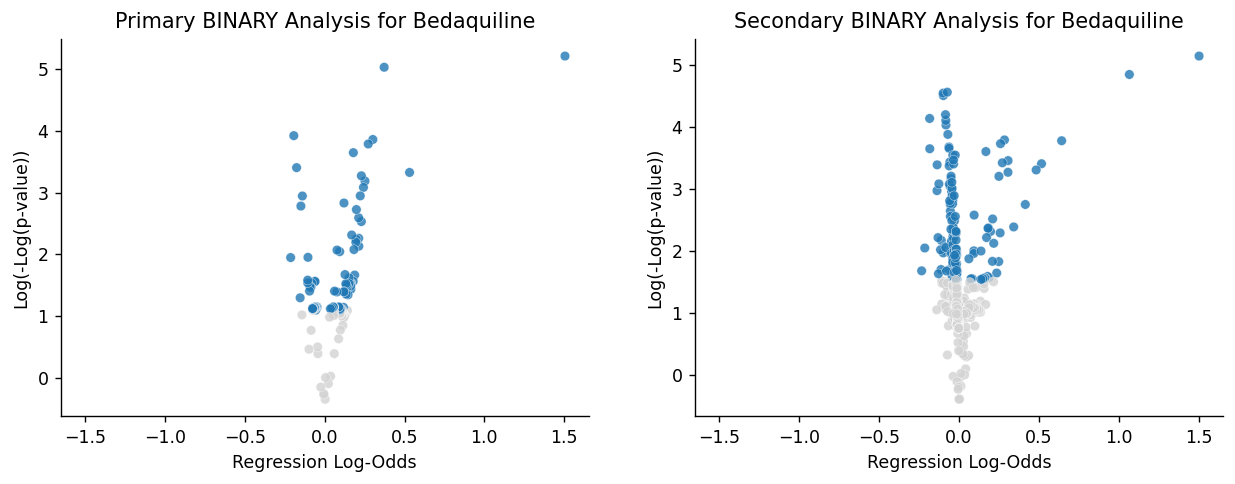

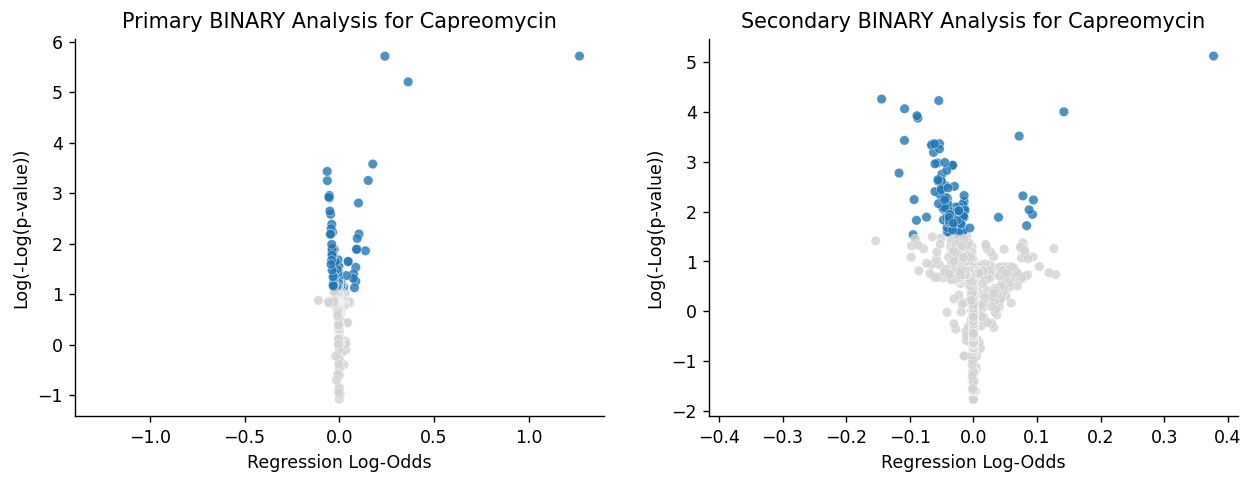

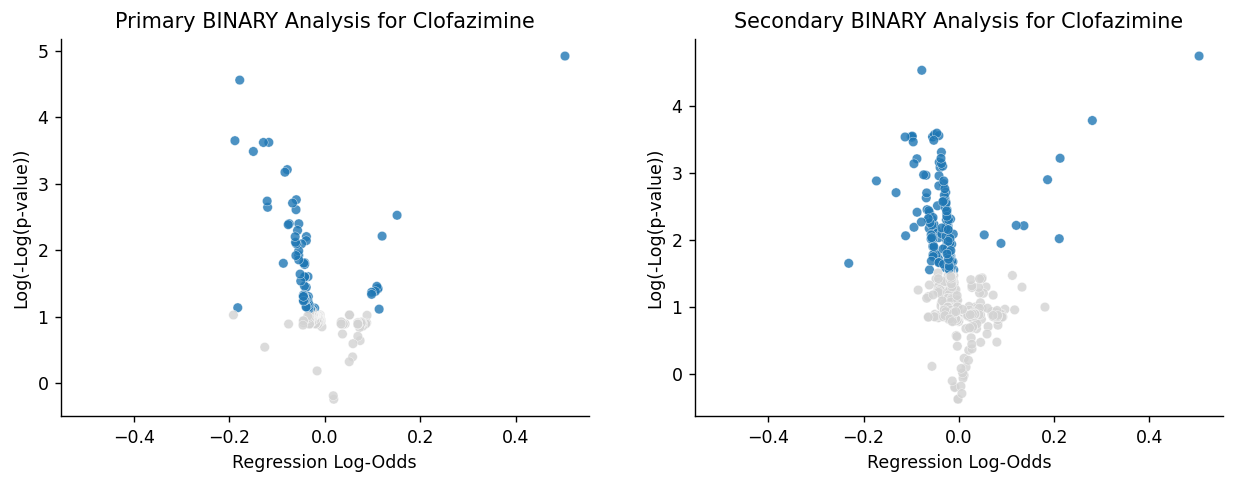

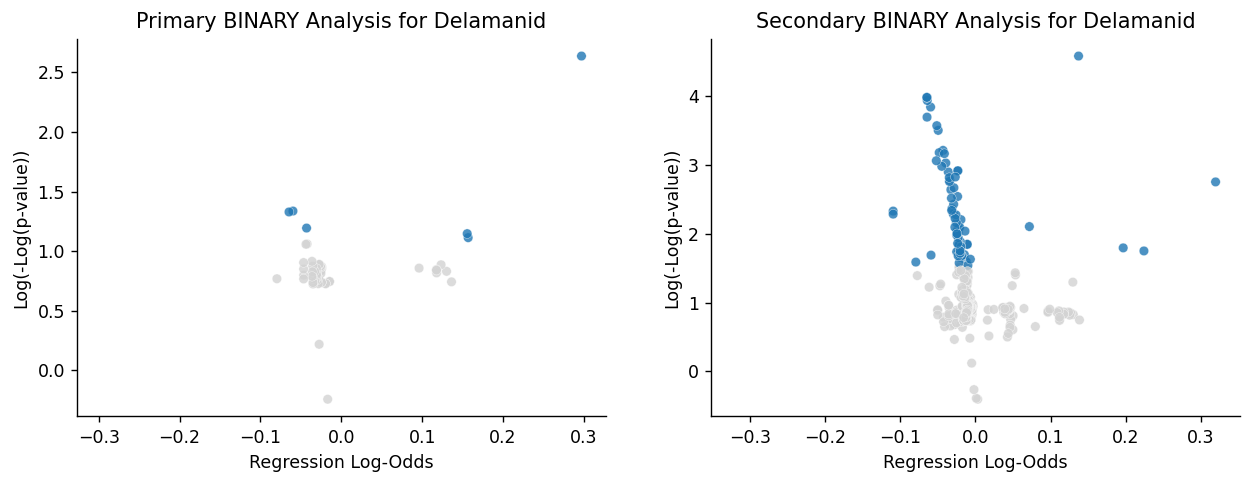

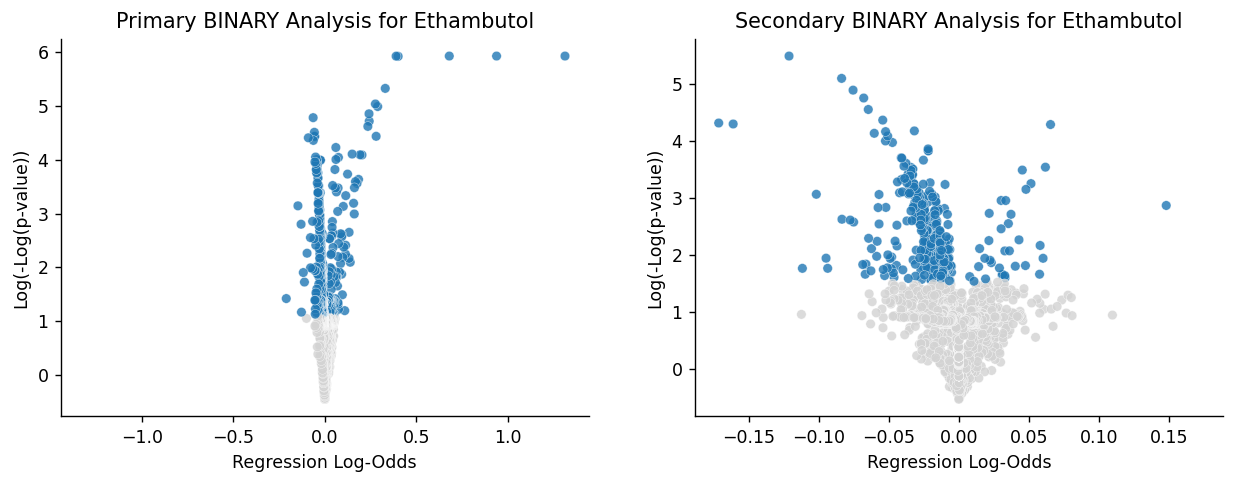

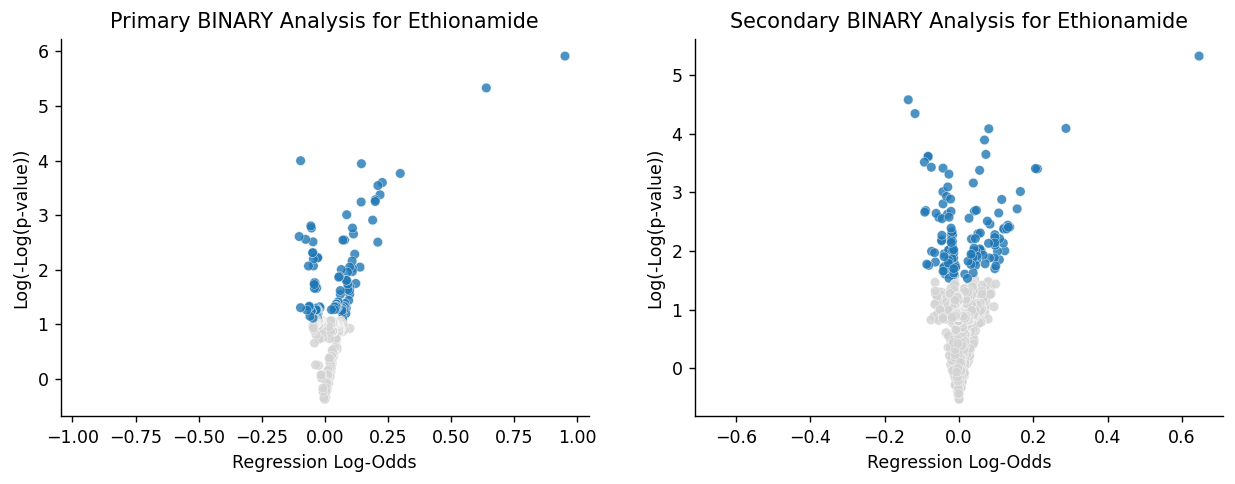

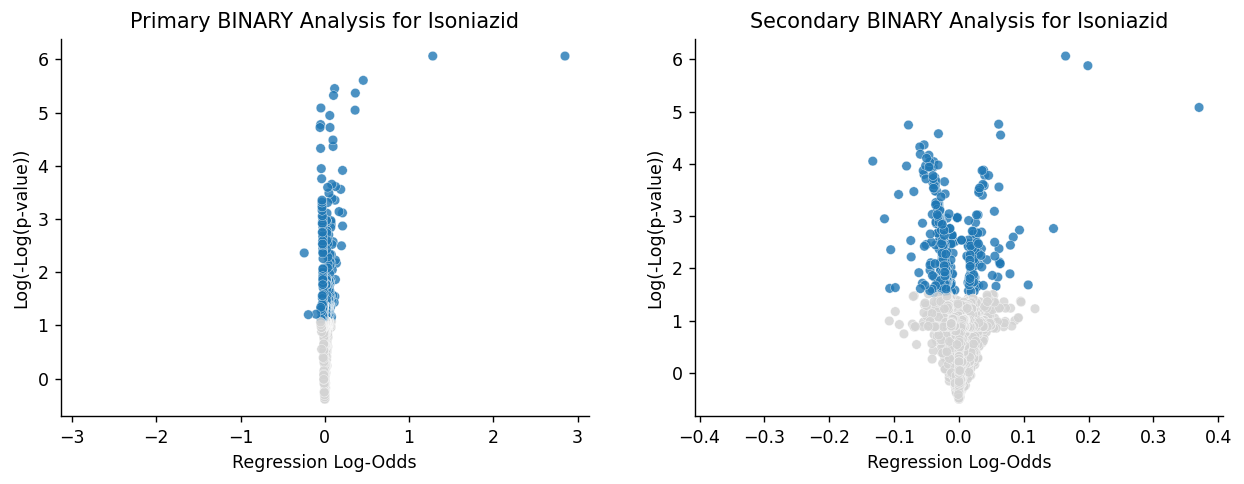

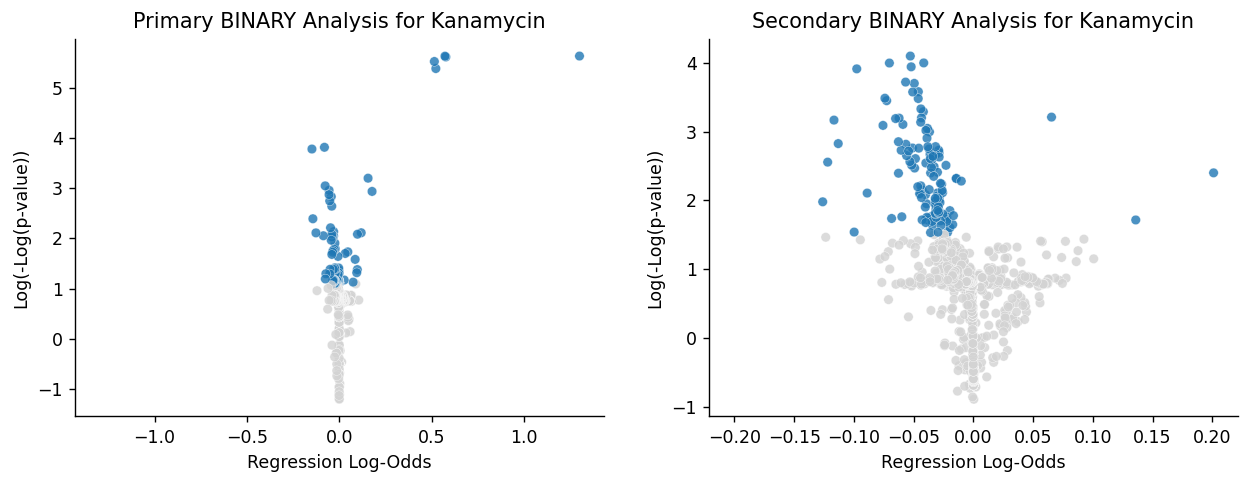

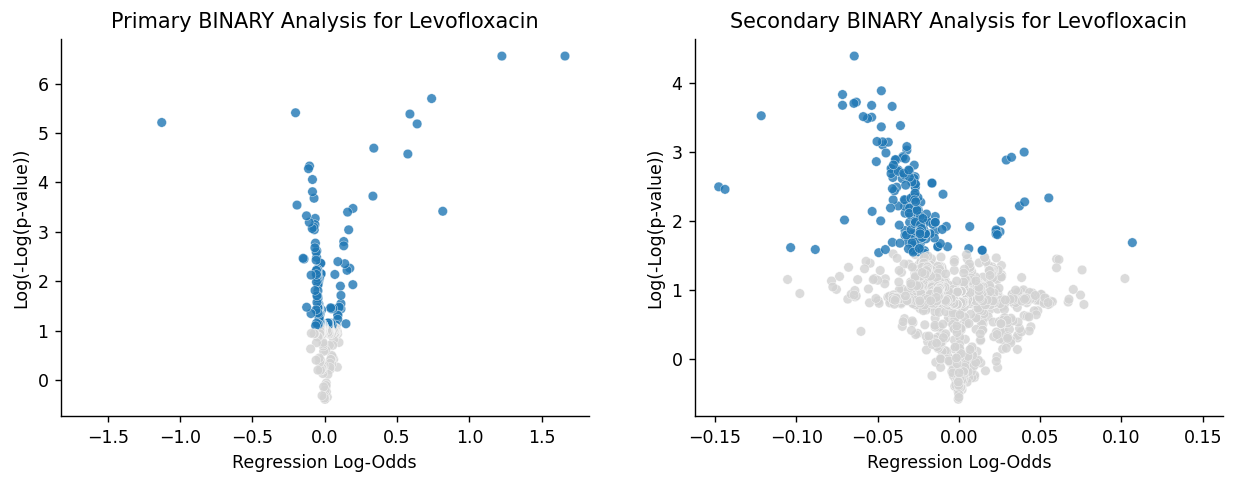

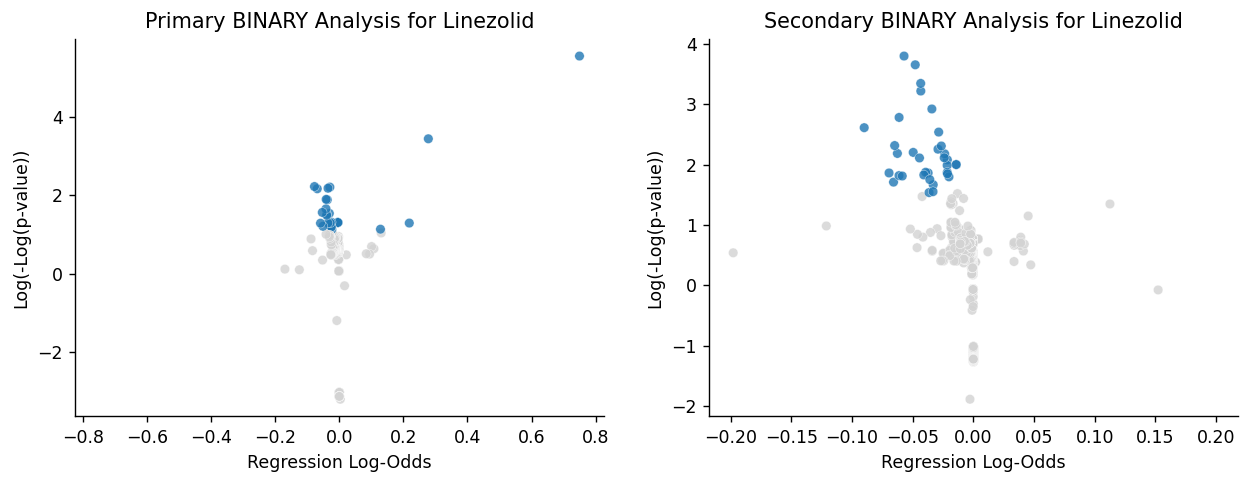

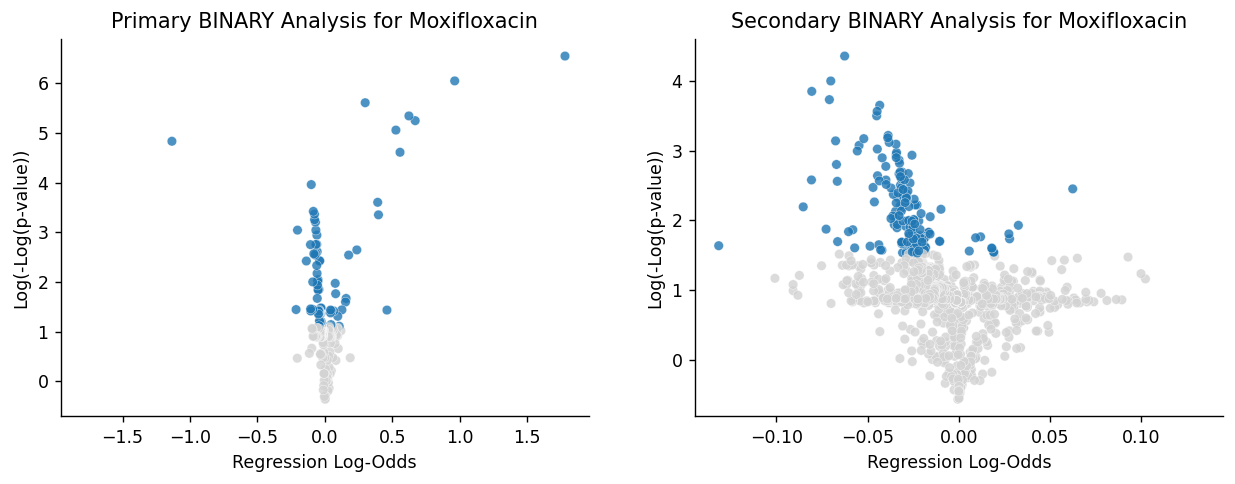

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


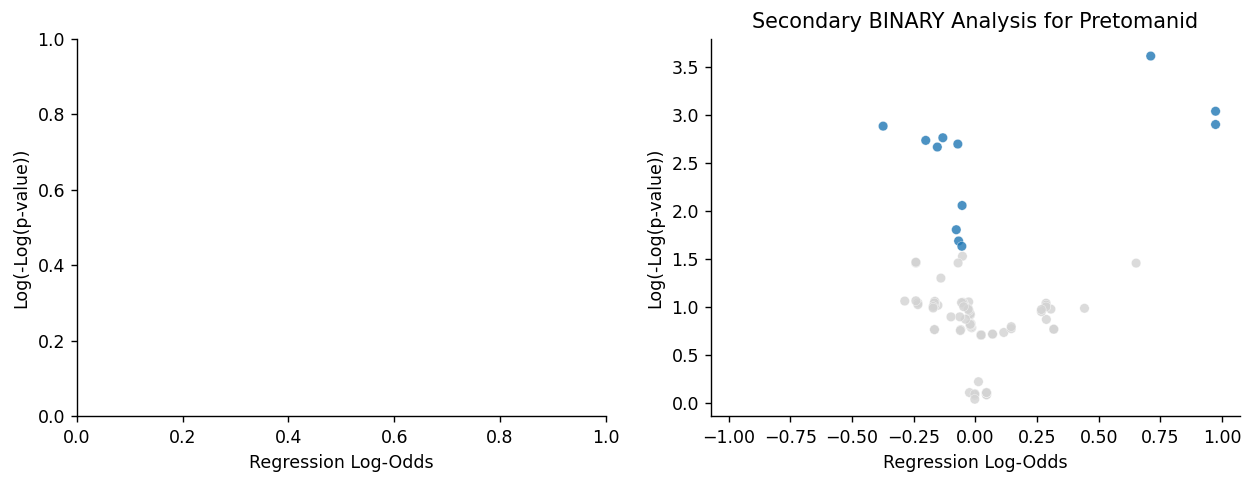

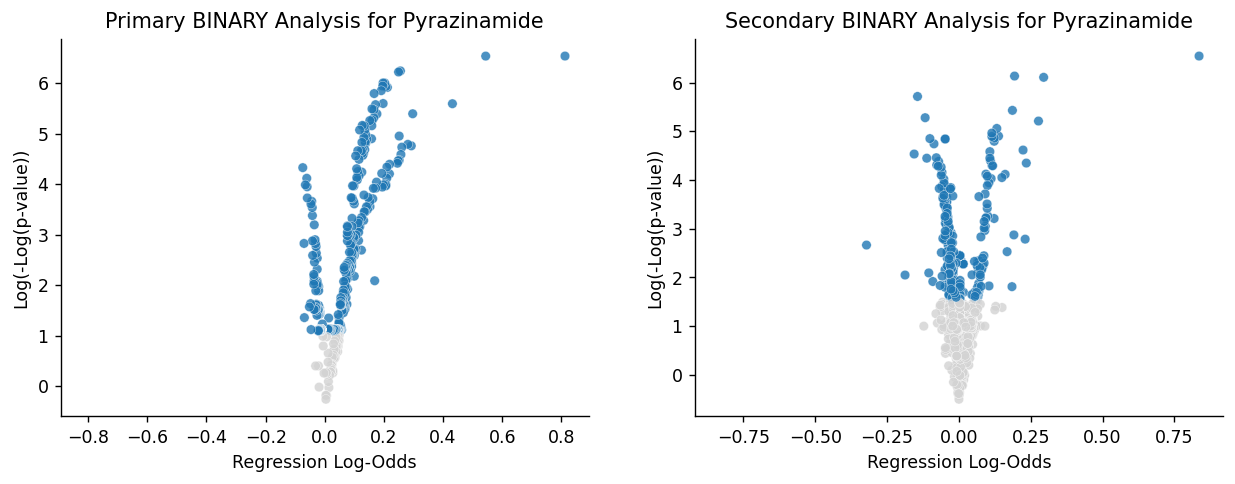

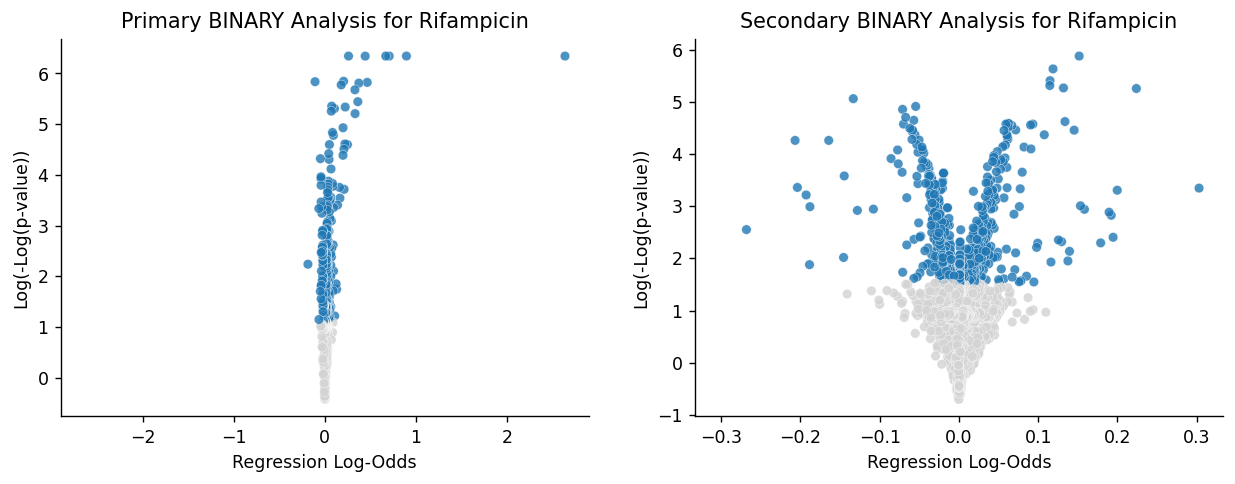

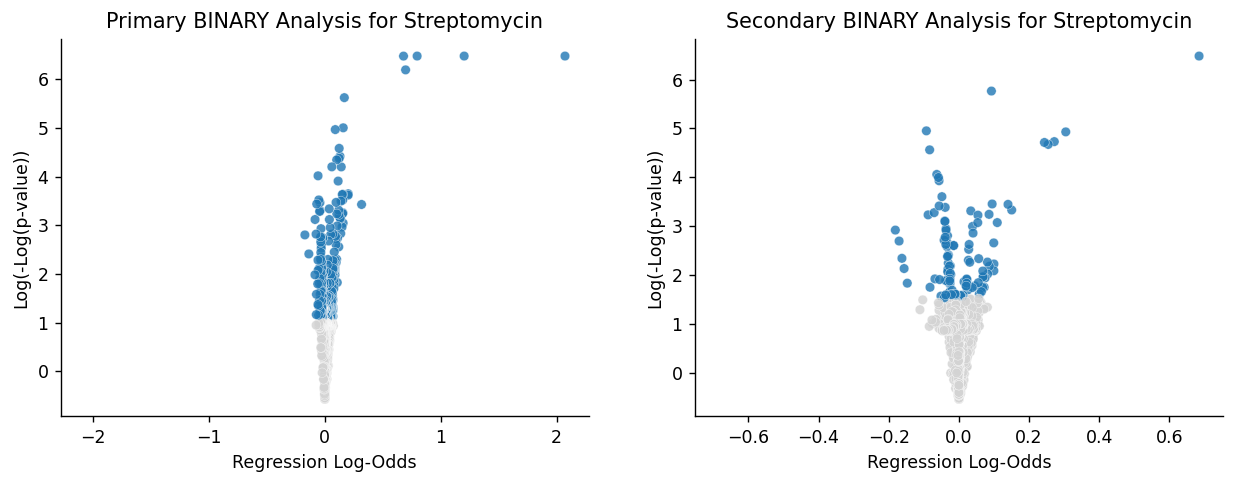

In [30]:
for drug in np.sort(drugs_lst):
    _ = volcano_plot(drug, "BINARY", "log_neg_log_pval", "BH_pval")#saveFig=f"../results/{drug}_volcano.png")